In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('companies_dataset_nounits.csv')
print(raw_data.head())

  company       company_type    year  quarter  quarterly_revenue_mil  \
0    Visa  payment_processor  2010.0      3.0                 1710.0   
1    Visa  payment_processor  2010.0      4.0                 1740.0   
2    Visa  payment_processor  2010.0      1.0                 1650.0   
3    Visa  payment_processor  2010.0      2.0                 1650.0   
4    Visa  payment_processor  2010.0      3.0                 1880.0   

   quarterly_revenue  gross_profit_mil  gross_profit  gross_margin  users_mil  \
0       1.710000e+09            1300.0  1.300000e+09         0.760     1670.0   
1       1.740000e+09            1350.0  1.350000e+09         0.775     1720.0   
2       1.650000e+09            1260.0  1.260000e+09         0.767     1720.0   
3       1.650000e+09            1270.0  1.270000e+09         0.770     1730.0   
4       1.880000e+09            1410.0  1.410000e+09         0.752     1770.0   

          users user_type  revenue_per_user        term_1  \
0  1.670000e+09    

the broad plan is to:
1. perform nonlinear regression on each company in this dataset
       * fitting to the Universal Scalability Law
       * USL information found here: https://cdn2.hubspot.net/hubfs/498921/eBooks/scalability_new.pdf
       * nonlinear least-squares regression plan on pg. 18
2. write a classification algorithm to see if w

In [3]:
# let's first separate the companies from each other
companies = raw_data['company'].unique()
company_data = {}
for company in companies:
    company_data[company] = raw_data[raw_data['company'] == company]

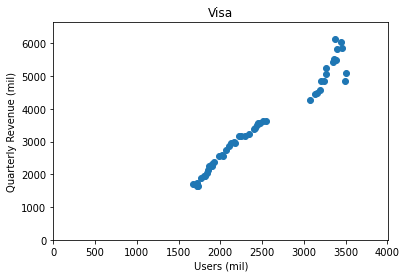

In [4]:
# the USL is a general "law" that can apply to any system - here the company is the system
# the "throughput" of the company is the revenue
# the "nodes" of the company are the users/customers (this isn't immediately obvious)

# so let's graph nodes vs. throughput
plt.scatter(
    x=company_data['Visa']['users_mil'], 
    y=company_data['Visa']['quarterly_revenue_mil'],
)
plt.xlim(0, company_data['Visa']['users_mil'].max() + 500)
plt.ylim(0, company_data['Visa']['quarterly_revenue_mil'].max() + 500)
plt.title('Visa')
plt.xlabel('Users (mil)')
plt.ylabel('Quarterly Revenue (mil)')
plt.show()

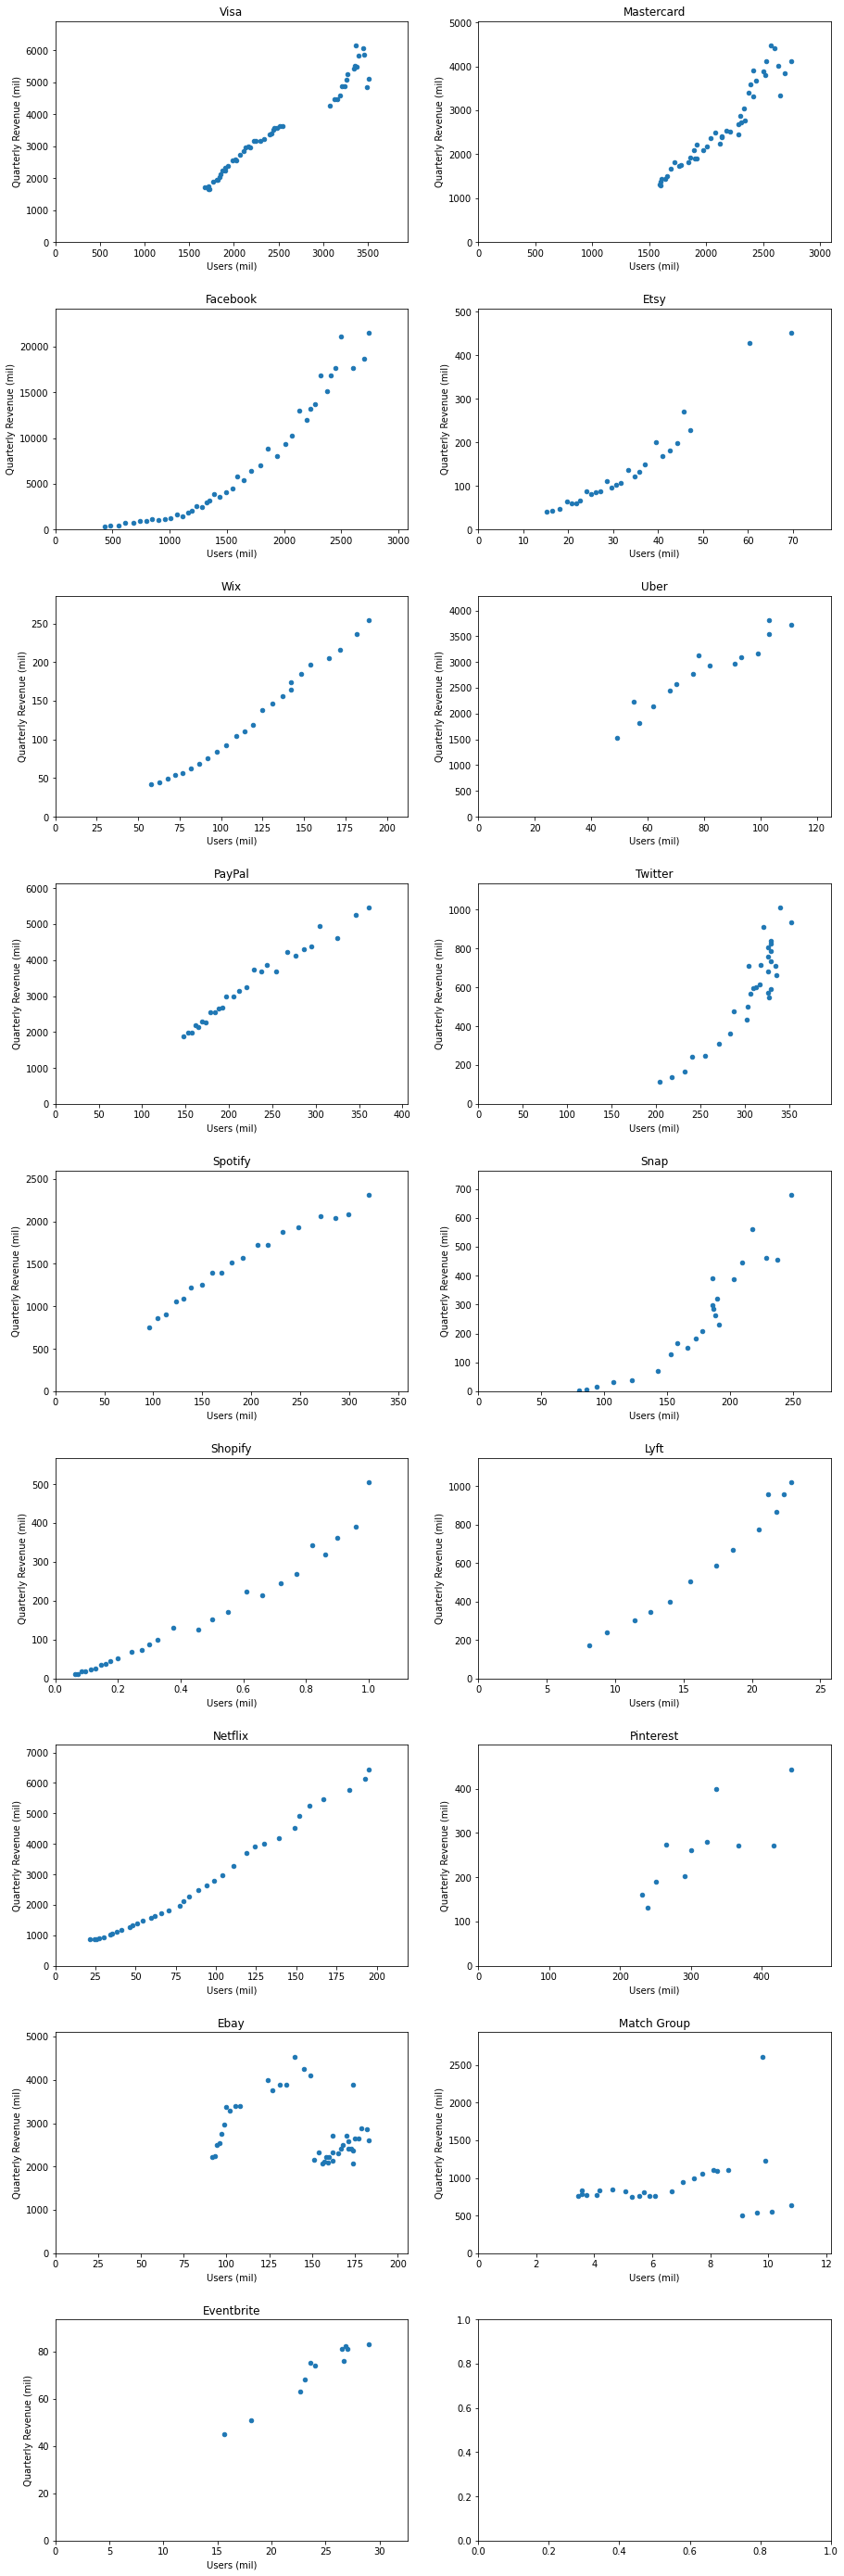

In [5]:
# all companies user vs. revenue graphs

fig, axs = plt.subplots(9, 2, figsize=(15,50))
for i, c in enumerate(companies):
    # cplt = user_rev_fig.add_subplot(1, 1, 1)
    spxi = int(np.floor(i/2))
    spyi = i % 2
    company_data[c].plot(
        kind='scatter',
        x='users_mil',
        y='quarterly_revenue_mil',
        ax=axs[spxi, spyi],
        xlabel='Users (mil)',
        ylabel='Quarterly Revenue (mil)',
        title=c,
    )
    xmax = company_data[c]['users_mil'].max()
    ymax = company_data[c]['quarterly_revenue_mil'].max()
    axs[spxi, spyi].set_xlim(0, xmax + xmax/8)
    axs[spxi, spyi].set_ylim(0, ymax + ymax/8)
plt.subplots_adjust(hspace=0.3)
plt.show()

Nonlinear least-squares regression: https://en.wikipedia.org/wiki/Non-linear_least_squares

Leads me to the Gauss-Newton algorithm: https://en.wikipedia.org/wiki/Gauss%E2%80%93Newton_algorithm

So that's what we'll attempt to implement

To carry out the steps:

1. We start with an initial guess for the parameters, lambda, sigma, and kappa

2. We need the jacobian matrix, which requires the gradient of the USL

3. We need to calculate the residuals of our data

4. Then carry out the nls regression, updating the parameters beta at each step - we stop when we've reached a convergence criterion


## Universal Scalability Law Equation
R(u) = (lambda * u) / (1 + sigma * (u-1) + kappa * u * (u-1))
## Gradients
we have to solve for the partial derivative of the residual w/ respect to each parameter

residual function is Y - usl(X, lambda, sigma, kappa)

dr / dlambda = u / (1 + sigma * (u-1) + kappa * u * (u-1))

dr / dsigma  = (lambda * u * (u-1)) / (1 + sigma * (u-1) + kappa * u * (u-1))^2

dr / dkappa  = (lambda * u^2 * (u-1)) / (1 + sigma * (u-1) + kappa * u * (u-1))^2

In [68]:
'''
u - # users (x-value)
beta - model params - (3,1) shape - (lmda, sigma, kappa)
'''
def dr_dlambda (u, beta):
    return u / (1 + beta[1]*(u-1) * beta[2]*u*(u-1))
def dr_dsigma (u, beta):
    return (beta[0] * u * (u-1)) / (1 + beta[1]*(u-1) + beta[2]*u*(u-1))**2
def dr_dkappa (u, beta):
    return (beta[0] * (u**2) * (u-1)) / (1 + beta[1]*(u-1) + beta[2]*u*(u-1))**2

def usl (u, beta):
    return (beta[0] * u) / (1 + beta[1]*(u-1) * beta[2]*u*(u-1))

In [80]:
# let's define the goal func and see what we need as we go along

def usl_nls_regression(x, y, beta0, gradient):
    '''
    x - x values - shape (?, 1)
    y - y values - shape (?, 1)
    beta0 - initial parameter values - (lambda, sigma, kappa)
    gradient - model's gradient matrix - shape (3,1)
    '''
    assert len(x) > len(beta0)
    assert beta0.shape == gradient.shape
    
    # initialize jacobian
    Jacobian = np.zeros((len(x), len(beta0)))
    
    # the parameter vector
    beta = beta0
    print('beta0', beta)
    
    num_iterations = 0
    
    # iterate
    while True:
        beta_prev = beta
        
        Jacobian[:, 0] = gradient[0](x, beta)
        Jacobian[:, 1] = gradient[1](x, beta)
        Jacobian[:, 2] = gradient[2](x, beta)
        
        residuals = y - usl(x, beta)
        
        temp1 = np.linalg.inv(np.dot(Jacobian.T, Jacobian))
        temp2 = np.dot(temp1, Jacobian.T)
        update_var = np.dot(temp2, residuals)
        
        beta = beta - update_var
        
        num_iterations += 1
        if num_iterations % 2 == 0:
            print(num_iterations)
            print('residuals: ', residuals)
            print('beta: ', beta)
        if num_iterations % 20 == 0:
            break
        
        # convergence criteria
        if (max(abs(beta_prev - beta))) <= 0.00001:
            break

    
    print(beta)

visa_initial_lmda  = company_data['Visa']['revenue_per_user'][0]
visa_initial_sigma = company_data['Visa']['gross_margin_density'][0]
visa_initial_kappa = company_data['Visa']['gmd_coef'][0]
visa_initial = np.array([visa_initial_lmda, visa_initial_sigma, visa_initial_kappa])

usl_gradients = np.array([dr_dlambda, dr_dsigma, dr_dkappa])

visa_users = np.array(company_data['Visa']['users_mil'])
visa_rev   = np.array(company_data['Visa']['quarterly_revenue_mil'])
    
    

In [81]:
usl_nls_regression(visa_users, visa_rev, visa_initial, usl_gradients)

beta0 [ 1.02e+00  4.54e-10 -3.88e-10]
2
residuals:  [  -16464.35994815   -26294.68749668   -26384.68749668   -29788.65249347
   -59178.0885031  -1035050.29488563   348177.04397906    96418.57455585
    71331.7063834     31882.69896493    47378.27864558    31962.69896493
    24441.36434057    17130.46750232    15039.8205281     14452.5964518
    12750.64384333    11507.56102275    11064.21024998    10392.95734042
     9952.90533711     9442.74026109     9001.00897111     8384.60893374
     8044.8534969      7683.79076534     7565.61981173     7536.78058922
     7520.58727361     7333.75853811     7222.79740515     7016.20505384
     6128.20076223     6247.40362208     6221.77951129     6268.1278597
     6530.06088672     6489.42615939     6673.26705515     6830.45542423
     6923.94038361     6992.57582075     6950.28108878     7278.54764041
     7611.35696825     7436.5371197      7226.51427923     6187.16434123
     6428.17576391]
beta:  [ 4.74310338e+00 -1.02647618e-03  9.49957472e-0

In [91]:
# it looks like lambda is an exploding gradient
# let's just try to fix lambda to be the rev / user, because that is the intuition for that parameter

def usl_nls_regression(x, y, beta0, gradient):
    '''
    x - x values - shape (?, 1)
    y - y values - shape (?, 1)
    beta0 - initial parameter values - (lambda, sigma, kappa)
    gradient - model's gradient matrix - shape (3,1)
    '''
    assert len(x) > len(beta0)
    assert beta0.shape == gradient.shape
    
    # initialize jacobian
    Jacobian = np.zeros((len(x), len(beta0)))
    
    # the parameter vector
    beta = beta0
    print('beta0', beta)
    
    num_iterations = 0
    
    # iterate
    while True:
        beta_prev = beta
        
        Jacobian[:, 0] = gradient[0](x, beta)
        Jacobian[:, 1] = gradient[1](x, beta)
        Jacobian[:, 2] = gradient[2](x, beta)
        
        residuals = y - usl(x, beta)
        
        temp1 = np.linalg.inv(np.dot(Jacobian.T, Jacobian))
        temp2 = np.dot(temp1, Jacobian.T)
        update_var = np.dot(temp2, residuals)
        
        beta = beta - update_var
        #fix lambda:
        # beta[0] = beta0[0]
        
        num_iterations += 1
        
        # we'll stop after 200 iterations
        if num_iterations % 300 == 0:
            print('iterations: ', num_iterations)
            print('update_var: ', update_var)
            print('beta: ', beta)
            break
        
        # convergence criterion
        if (max(abs(beta_prev - beta))) <= 0.000001:
            break

    
    return beta

In [92]:
params = usl_nls_regression(visa_users, visa_rev, visa_initial, usl_gradients)

# fix beta param
params[0] = visa_initial[0]

beta0 [ 1.02e+00  4.54e-10 -3.88e-10]
iterations:  300
update_var:  [-1.00687271e+90 -6.77626358e-17  6.08804931e-21]
beta:  [ 2.01374541e+90 -8.82118449e-04  4.52086924e-09]


In [93]:
def print_params(beta):
    print('lambda: ', beta[0])
    print('sigma: ', beta[1])
    print('kappa: ', beta[2])

In [95]:
# okay... now let's see what this function looks like
def data_model_plot(company_name, params):
    users = company_data[company_name]['users_mil']
    quarterly_rev = company_data[company_name]['quarterly_revenue_mil']

    # plot datapoints
    plt.scatter(x=users, y=quarterly_rev)
    plt.xlim(0, users.max() + 500)
    plt.ylim(0, quarterly_rev.max() + 500)
    plt.title(company_name)
    plt.xlabel('Users (mil)')
    plt.ylabel('Quarterly Revenue (mil)')

    # plot USL w/ params from regression
    usl_x = np.linspace(0, 4000, num=100)
    usl_y = usl(usl_x, params)
    plt.plot(usl_x, usl_y, 'r--')
    plt.show()
    
    print_params(params)

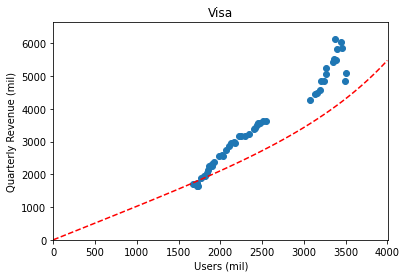

lambda:  1.02
sigma:  -0.0008821184485506437
kappa:  4.520869238805904e-09


In [96]:
data_model_plot('Visa', params)

Visa
beta0 [ 1.02e+00  4.54e-10 -3.88e-10]
iterations:  300
update_var:  [-1.00687271e+90 -6.77626358e-17  6.08804931e-21]
beta:  [ 2.01374541e+90 -8.82118449e-04  4.52086924e-09]


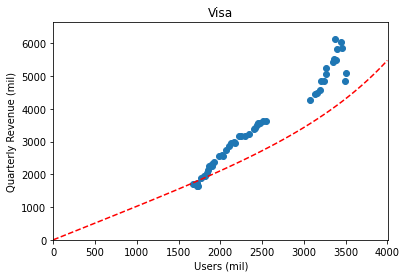

lambda:  1.02
sigma:  -0.0008821184485506437
kappa:  4.520869238805904e-09
Mastercard
beta0 [ 8.10e-01  2.25e-10 -1.69e-10]
iterations:  300
update_var:  [-4.61224405e+90  3.52180583e-18 -1.31153606e-21]
beta:  [ 9.22448812e+90 -3.98294353e-03  2.08913347e-06]


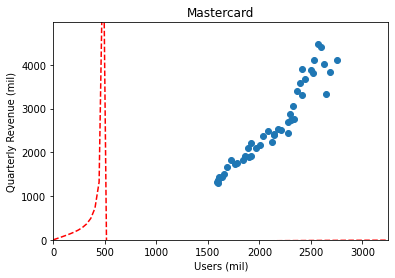

lambda:  0.81
sigma:  -0.003982943534785842
kappa:  2.0891334719776717e-06
Facebook
beta0 [ 8.00e-01  1.65e-09 -1.43e-09]
iterations:  300
update_var:  [ 1.82861925e+97  1.61071785e-17 -1.22925656e-19]
beta:  [-3.65723850e+97 -1.26093871e+00  5.54096593e-03]


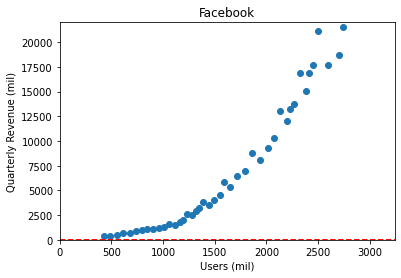

lambda:  0.8
sigma:  -1.2609387053787022
kappa:  0.005540965933469342
Etsy
beta0 [ 2.69e+00  4.00e-08 -1.68e-08]
iterations:  300
update_var:  [-2.38004743e+90 -1.51788304e-18  7.96210970e-20]
beta:  [ 4.76009486e+90 -4.07416251e-02  7.04657934e-05]


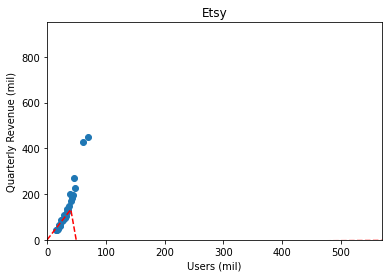

lambda:  2.69
sigma:  -0.04074162506062839
kappa:  7.046579335916402e-05
Wix
beta0 [ 7.20e-01  1.40e-08 -1.23e-08]
iterations:  300
update_var:  [-7.31520168e+89  1.68051337e-18 -5.50571416e-20]
beta:  [ 1.46304034e+90 -1.49194679e-02  1.80554055e-05]


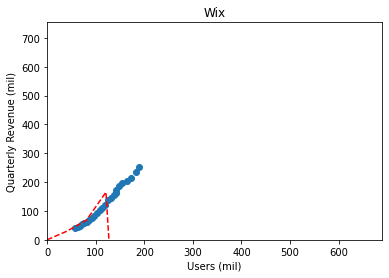

lambda:  0.72
sigma:  -0.014919467928504534
kappa:  1.8055405452601705e-05
Uber
beta0 [ 3.10e+01  9.46e-09 -4.25e-04]
iterations:  300
update_var:  [-2.92304360e+92  4.55193814e-12 -1.23312307e-13]
beta:  [ 5.82713469e+92 -8.68882009e-02  1.34822944e-03]


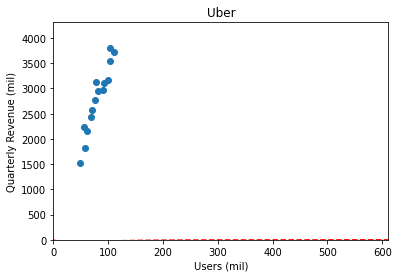

lambda:  31.0
sigma:  -0.0868882009296042
kappa:  0.0013482294439038395
PayPal
beta0 [1.26e+01 3.51e-09 5.67e-09]
iterations:  300
update_var:  [-1.04306467e+91  2.99104274e-17 -1.02120410e-19]
beta:  [ 2.08612935e+91 -6.30035975e-03  1.10242316e-05]


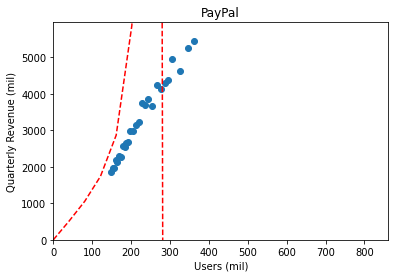

lambda:  12.6
sigma:  -0.006300359749943491
kappa:  1.1024231602908547e-05
Twitter
beta0 [ 0.56     0.00314 -0.00182]
iterations:  300
update_var:  [-1.15914596e+112  2.21888751e-017 -8.75074370e-020]
beta:  [ 2.31829193e+112  6.32570083e+008 -2.10179056e+006]


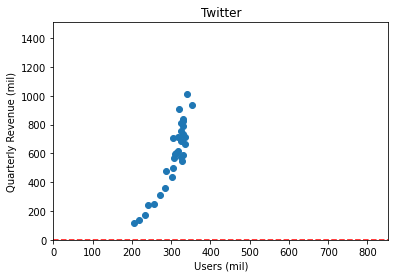

lambda:  0.56
sigma:  632570083.4110819
kappa:  -2101790.5551822986
Spotify
beta0 [7.80e+00 5.22e-10 8.64e-09]
iterations:  300
update_var:  [-2.27255896e+90 -4.33680869e-19  7.19978005e-21]
beta:  [ 4.54511791e+90 -7.37312487e-03  1.52569993e-05]


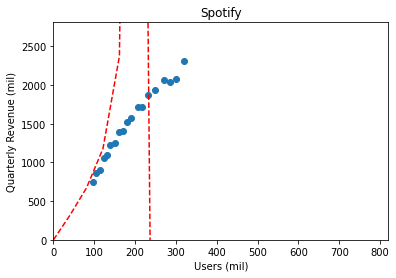

lambda:  7.8
sigma:  -0.0073731248678855586
kappa:  1.5256999250691292e-05
Snap
beta0 [ 5.00e-02 -5.45e-08  5.46e-08]
iterations:  300
update_var:  [-1.22053877e+97 -3.46436475e-19 -6.42884772e-21]
beta:  [ 2.44107754e+97 -7.13746882e+01  4.61253336e-01]


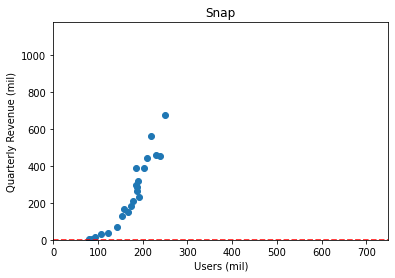

lambda:  0.05
sigma:  -71.37468815940262
kappa:  0.4612533356016379
Shopify
beta0 [1.70e+02 1.30e-05 3.74e-04]
iterations:  300
update_var:  [ 3.01022773e+92 -1.28230759e-14 -4.99600361e-15]
beta:  [-6.02045546e+92  2.63214144e+00  2.46653148e+00]


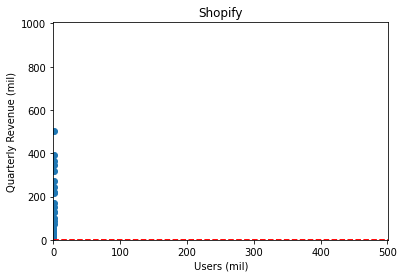

lambda:  170.0
sigma:  2.6321414369188427
kappa:  2.4665314839566226
Lyft
beta0 [ 5.00e-02  3.85e-08 -3.78e-08]
iterations:  300
update_var:  [-2.15959056e+102  3.40331062e-016 -1.04286696e-017]
beta:  [ 4.31918112e+102 -8.41886939e+004  4.08650663e+003]


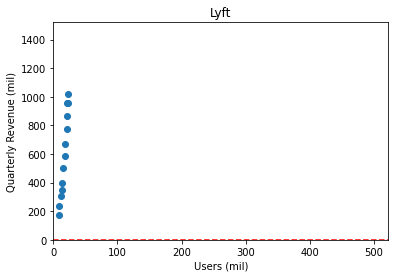

lambda:  0.05
sigma:  -84188.69391951566
kappa:  4086.5066250482923
Netflix
beta0 [ 4.10e+01  1.59e-08 -1.07e-08]
iterations:  300
update_var:  [-1.54792865e+91 -1.34441069e-16  4.09116914e-19]
beta:  [ 3.09585730e+91 -2.30202721e-03  2.56024018e-06]


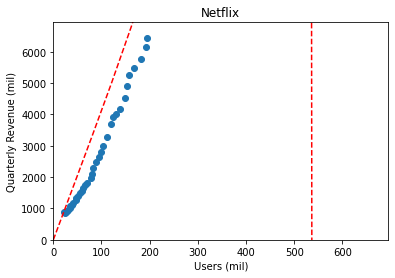

lambda:  41.0
sigma:  -0.0023020272091334735
kappa:  2.5602401800306153e-06
Pinterest
beta0 [ 5.50e-01  2.56e-09 -2.27e-09]
iterations:  300
update_var:  [-2.99969736e+90 -1.34441069e-17 -3.38813179e-21]
beta:  [ 5.99939472e+90  3.11703101e-02 -5.83909763e-05]


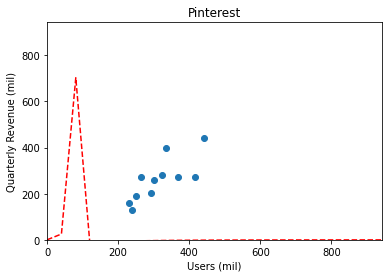

lambda:  0.55
sigma:  0.031170310109776493
kappa:  -5.839097630808142e-05
Ebay
beta0 [2.41e+01 7.87e-09 2.03e-08]
iterations:  300
update_var:  [-1.68220565e+97  1.50433051e-18 -2.01170325e-20]
beta:  [ 3.36441130e+97  4.31977943e+01 -2.28538721e-01]


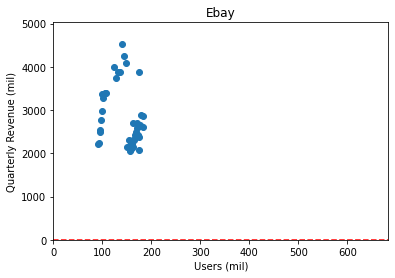

lambda:  24.1
sigma:  43.19779433233227
kappa:  -0.22853872089538507
Match Group
beta0 [2.19e+02 2.09e-07 6.94e-06]
iterations:  300
update_var:  [-6.20718615e+91 -3.13768109e-15  3.67219276e-16]
beta:  [ 1.24143723e+92 -2.49785762e-01  1.10715513e-02]


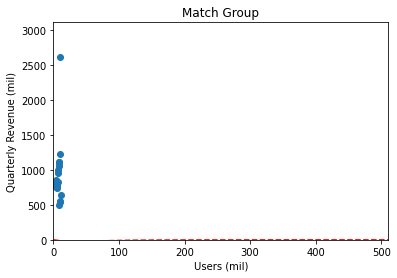

lambda:  219.0
sigma:  -0.24978576212449952
kappa:  0.01107155134548002
Eventbrite
beta0 [ 2.88e+00  3.85e-08 -1.43e-08]
iterations:  300
update_var:  [-2.27736921e+90 -4.53630189e-16  1.53956708e-17]
beta:  [ 4.55473842e+90 -6.89451854e-02  1.48204371e-03]


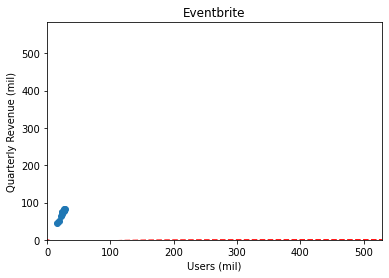

lambda:  2.88
sigma:  -0.06894518542315205
kappa:  0.0014820437118552572


In [125]:
# let's look at some other companies

for company in companies:
    print(company)
    initial_lmda  = list(company_data[company]['revenue_per_user'])[0]
    initial_sigma = list(company_data[company]['gross_margin_density'])[0]
    initial_kappa = list(company_data[company]['gmd_coef'])[0]
    initial_param_values = np.array([initial_lmda, initial_sigma, initial_kappa])

    usl_gradients = np.array([dr_dlambda, dr_dsigma, dr_dkappa])

    users = np.array(company_data[company]['users_mil'])
    rev   = np.array(company_data[company]['quarterly_revenue_mil'])
    
    params = usl_nls_regression(users, rev, initial_param_values, usl_gradients)
    params[0] = initial_param_values[0]
    
    data_model_plot(company, params)

In [126]:
# alright, not good
# at all!
